get data
id:  3657
max integer:  32767 -32767
unit is dBm


/tmp/ipykernel_274062/2502910374.py:84: RuntimeWarning: divide by zero encountered in log10
  out = 10.*np.log10(np.abs(data/data.size)**2/50/0.001)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
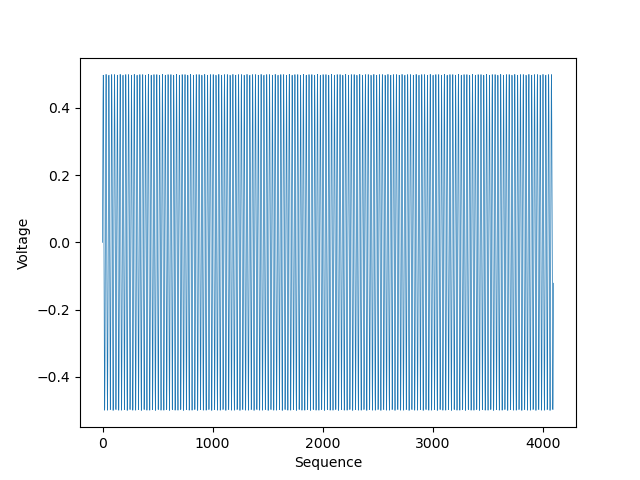

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
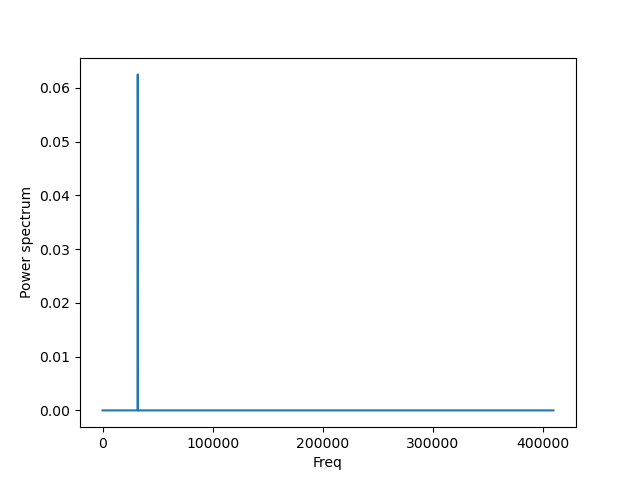

In [8]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
# vim:fenc=utf-8
#
# Copyright © 2021 gq <gq@gqhp>
#
# Distributed under terms of the MIT license.

"""
test DAC sampling
"""
%matplotlib widget

import socket
import numpy as np

from numpy.fft import fft,rfft,rfftfreq
import matplotlib.pyplot as plt

# src_udp_ip = "192.168.90.20"
# src_udp_ip = "127.0.0.1"
# src_udp_port = 59000


udp_ip = "192.168.90.100"
udp_port = 60000

udp_ip = "127.0.0.1"
udp_port = 50001

sock = socket.socket(socket.AF_INET,  socket.SOCK_DGRAM, socket.IPPROTO_UDP)
sock.bind((udp_ip, udp_port))
# sock.setsockopt(socket.SO_NO_CHECK,1)


# sock.setsockopt(socket.IPPROTO_UDP, 1, 1)

# sock.connect((src_udp_ip, src_udp_port))
# data, addr=sock.recvfrom(8000)

packet_size = 8192
size = 8200

udp_data = sock.recv(size)
udp_data = memoryview(udp_data)

print("get data")

chunk = np.frombuffer(udp_data[0:packet_size], dtype='>i2')

print("id: ", int.from_bytes(udp_data[8196:8200], 'big'))
print("max integer: ", chunk.max(), chunk.min())

scale_f = 0.5/ (2 ** 15)
real_data = chunk *  scale_f

sample_rate = 819200 #Mhz
timestep = 1.0/sample_rate

k = 2.23
beta = 16.7
       
kasier_fil = np.kaiser(packet_size//2, beta)
factor_kasier = np.sum(kasier_fil)

# fft_size = packet_size/2
# fft_data = rfft(real_data*kasier_fil)
fft_data = rfft(real_data)
freq = rfftfreq(packet_size//2, d=timestep)

# logdata = np.log10(np.abs(fft_data/(packet_size/2))**2)
logdata = np.abs(fft_data/(packet_size/2))**2

unit = 'dBm'


def fft_to_dBV(data):
    
    out = 20.*np.log10(np.abs(data/data.size))
    return out

def fft_to_dBm(data):
    
    out = 10.*np.log10(np.abs(data/data.size)**2/50/0.001)
    return out

if unit == 'dBm':
    print("unit is dBm")
    # should I remove factor_kasier
    # add factor=2 because the power of AC singals is 1/2
    # 
    # dbm_fft_data = 10*np.log10(np.abs(fft_data/fft_size/factor_kasier)**2/(1e-3)/50.0)
    dbm_fft_data = fft_to_dBm(fft_data)
    
# if unit == 'dBV':
#     print("unit is dBm")
#     # should I remove factor_kasier
#     # add factor=2 because the power of AC singals is 1/2
#     # 
#     dbm_fft_data = fft_to_dBV(fft_data)
    
sock.close()
# plt.plot(freq, logdata)
plt.figure()
plt.plot(np.arange(real_data.size), real_data, lw = 0.5)
# plt.plot(np.arange(real_data.size), real_data, 'o', ms=1.0)
plt.xlabel("Sequence")
plt.ylabel("Voltage")
# plt.ylim([0.0475,0.0650])
plt.show()

plt.figure()
plt.xlabel("Freq")
unit='dog'
if unit == 'dBm':
    plt.ylabel(unit)
    print("max dbm: ", dbm_fft_data.max())
    plt.plot(freq, dbm_fft_data)
else:
    plt.ylabel("Power spectrum")
    plt.plot(freq, logdata)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
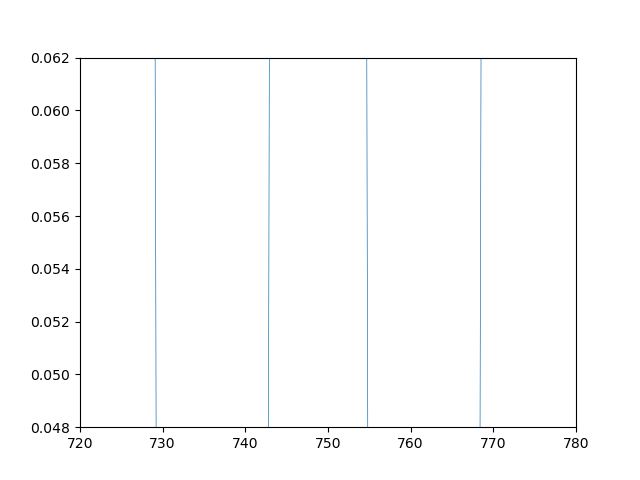

In [5]:
redata = real_data
redata[748],redata[749] =redata[749], redata[748]
plt.figure()
plt.plot(np.arange(real_data.size), redata, lw = 0.5)
plt.plot(np.arange(real_data.size), redata, 'o', ms=1.0)
plt.xlim([720, 780])
plt.ylim([0.048, 0.062])
plt.show()


# Test direct FFT result output
----

SRC MAC: 

SRC IP: 192.168.90.21

SRC port 59001

DST MAC: 00:1b:21:85:6e:a1

DST IP: 192.168.90.100

SRC port 6001

---



id_out now 4
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
get data
data point 32768 1073741823


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
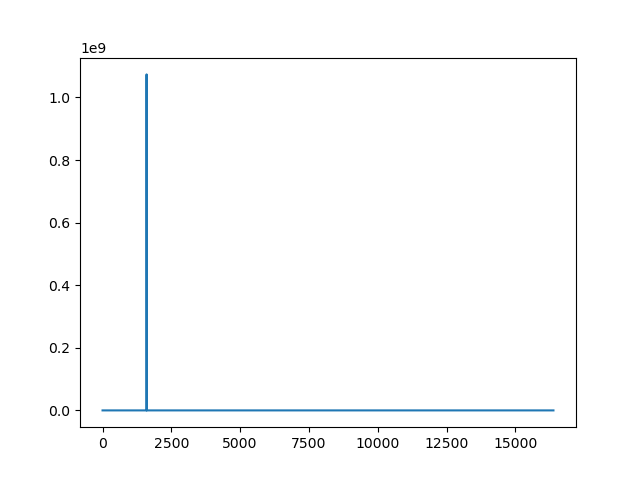

In [23]:
%matplotlib widget

import socket
import numpy as np

from numpy.fft import fft,rfft,rfftfreq
import matplotlib.pyplot as plt

src_udp_ip = "192.168.90.21"
src_udp_port = 59001


udp_ip = "192.168.90.100"
udp_port = 60001

udp_ip = "127.0.0.1"
udp_port = 60002

sock = socket.socket(socket.AF_INET,  socket.SOCK_DGRAM, socket.IPPROTO_UDP)
sock.bind((udp_ip, udp_port))
# sock.setsockopt(socket.SO_NO_CHECK,1)

sample_rate = 8192 * 8

# sock.setsockopt(socket.IPPROTO_UDP, 1, 1)

# sock.connect((src_udp_ip, src_udp_port))
# data, addr=sock.recvfrom(8000)

payload_size = 8200
data_size = 8192
id_size = 4

count = 16

udp_payload = bytearray(count*payload_size)
udp_data = bytearray(count*data_size)
udp_id = bytearray(count*id_size)

data_buff = memoryview(udp_data)
payload_buff = memoryview(udp_payload)
id_buff = memoryview(udp_id)

pi1 = 0
pi2 = data_size

hi1 = 0
hi2 = id_size

id_out = 0

while id_out % count != count-1:
    sock.recv_into(payload_buff, payload_size)
    id_out = int.from_bytes(payload_buff[payload_size - id_size:payload_size], 'big')

print('id_out now', id_out%15)

while count:
    sock.recv_into(payload_buff, payload_size)
    data_buff[pi1:pi2] = payload_buff[0:data_size]
    id_buff[hi1:hi2] = payload_buff[payload_size - id_size:payload_size] 
    pi1 += data_size
    pi2 += data_size
    hi1 += id_size
    hi2 += id_size
    
    id_out = int.from_bytes(payload_buff[payload_size - id_size:payload_size], 'big')
    print(id_out)
    
    count -= 1

print("get data")
sock.close()

chunk = np.frombuffer(udp_data, dtype='>u4')
tot_size = chunk.size
print("data point", chunk.size, chunk.max())
plt.plot(np.arange(chunk.size)/tot_size*sample_rate/2., chunk)
#plt.yscale('log')
plt.show()

In [32]:
chunk.max()

63225